# Objective

We will try to predict further move in stock based on:
1. AR models
2. Simple Averaging
3. Exponential Smoothing
4. ARIMA models
5. VAR models
6. State space methods
    - SARIMA models
7. RNN
8. LSTM
9. GRU

In this notebook i have used split adjusted top 3 pharma stock of indian pharma sector i.e. CIPLA, SUNPHARMA, DR-REDDY for overview and **one** (i.e. CIPLA) is selected for full analysis.

## About DataSet
Dataset contain stock price traded data with following columns :- 
- **Date** = Date of trading over NSE
- **Open** = current day open point
- **High** =  current day highest point
- **Low** =  current day lowest point
- **Close** =  Closing point for the current day
- **Adj Close**	= Close price adjusted for both dividends and splits.
- **Volume** = he amount of a security that was traded during a given period of time. For every buyer, there is a seller, and each transaction contributes to the count of total volume.

In [94]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams

In [95]:
miss_val=['null']
cipla=pd.read_csv('CIPLA.csv',na_values = miss_val,index_col='Date',parse_dates=['Date'])
cipla.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,8.778666,8.833333,8.773333,8.832000,7.563436,208125.0
1996-01-02,8.832000,9.013333,8.400000,8.720000,7.467525,1623750.0
1996-01-03,8.720000,8.880000,8.626666,8.658666,7.414997,721875.0
1996-01-04,8.658666,8.653333,8.400000,8.568000,7.337356,620625.0
1996-01-05,8.568000,8.640000,8.506666,8.546666,7.319087,350625.0


In [96]:
sunp=pd.read_csv('SUNPHARMA.csv',na_values = miss_val,index_col='Date',parse_dates=['Date'])
sunp.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,1.812932,1.804799,1.803250,1.803250,1.458367,38730.0
1996-01-02,1.800926,1.800926,1.743219,1.743219,1.409817,77460.0
1996-01-03,1.743219,1.750578,1.750578,1.750578,1.415769,12910.0
1996-01-04,1.746705,1.758324,1.742832,1.742832,1.409505,64550.0
1996-01-05,1.738572,1.738572,1.738572,1.738572,1.406059,12910.0


In [97]:
drreddy=pd.read_csv('DRREDDY.csv',na_values = miss_val,index_col='Date',parse_dates=['Date'])
drreddy

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,56.400002,56.500000,55.750000,55.750000,49.022575,2800.0
1996-01-02,55.750000,55.750000,55.262501,55.275002,48.604893,8400.0
1996-01-03,55.275002,55.625000,55.250000,55.299999,48.626877,11200.0
1996-01-04,55.299999,53.750000,53.037498,53.312500,46.879208,3600.0
1996-01-05,53.312500,53.987499,52.000000,52.049999,45.769058,12000.0
...,...,...,...,...,...,...
2021-04-16,4863.799805,4940.000000,4815.200195,4893.250000,4893.250000,1198029.0
2021-04-19,4893.000000,5005.000000,4807.049805,4968.100098,4968.100098,1843928.0
2021-04-20,5100.000000,5210.750000,5089.500000,5156.750000,5156.750000,3484976.0


## Cleaning and preparing time series data

As there are some null columns present in dataset we will delete this rows as our dataset is huge and won't affect the analysis.

In [98]:
cipla[cipla['Open'].isnull()==True].shape

(26, 6)

In [99]:
sunp[sunp['Open'].isnull()==True].shape

(14, 6)

In [100]:
drreddy[drreddy['Open'].isnull()==True].shape

(17, 6)

In [101]:
cipla=cipla.dropna(how='any',axis=0)
sunp=sunp.dropna(how='any',axis=0)
drreddy=drreddy.dropna(how='any',axis=0)

In [102]:
cipla.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6353 entries, 1996-01-01 to 2021-04-23
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6353 non-null   float64
 1   High       6353 non-null   float64
 2   Low        6353 non-null   float64
 3   Close      6353 non-null   float64
 4   Adj Close  6353 non-null   float64
 5   Volume     6353 non-null   float64
dtypes: float64(6)
memory usage: 347.4 KB


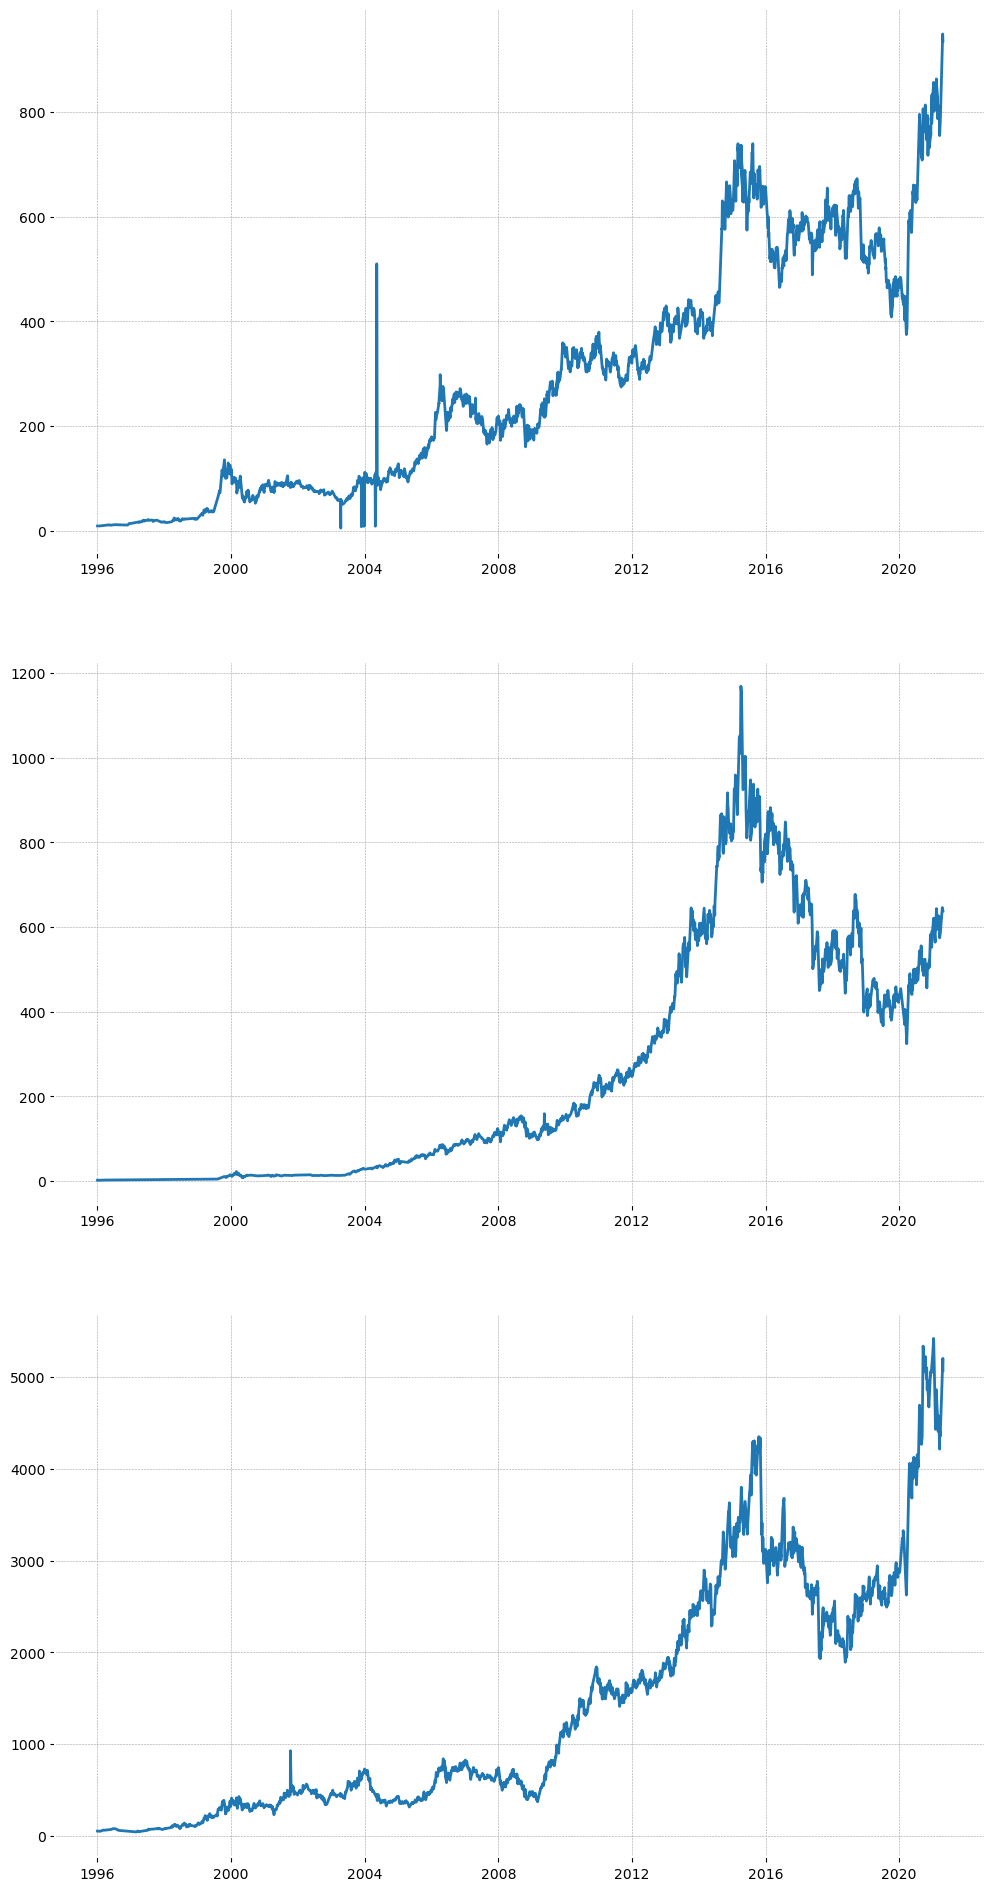

In [103]:
fig,ax=plt.subplots(3,1,figsize=(12,24))
ax[0].plot(cipla.Close)
ax[1].plot(sunp.Close)
ax[2].plot(drreddy.Close)
fig.show()

As some spikes is seen in 1st and 3rd plot i.e.
- 2003 to 2005 in **Cipla**
- 2001 to 2003 in **Dr Reddy**

There for all 3 dataset, data will be taken from year 2005 till date.


In [104]:
#example for data miss handeled.
drreddy['2001-10-08':'2001-10-15']

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-10-08,441.5,456.25,437.500000,447.337494,393.356750,710896.0
2001-10-09,447.5,452.00,443.774994,447.262512,393.290680,575792.0
2001-10-10,894.0,919.50,893.099976,914.724976,804.344055,241630.0
2001-10-11,905.0,935.00,905.000000,929.075012,816.962463,263622.0
2001-10-12,928.5,939.50,922.000000,926.700012,814.873962,142796.0
2001-10-15,465.0,469.00,461.549988,463.549988,407.612793,427898.0


**There is some error occured while fetching as price is doubled for period of 3 days**

Therefore we can either divide by 2 following 3 columns or i have selected dataset after this time period as already we have huge dataset.

In [105]:
#Range Selection
cipla=cipla['2005':]
sunp=sunp['2005':]
drreddy=drreddy['2005':]

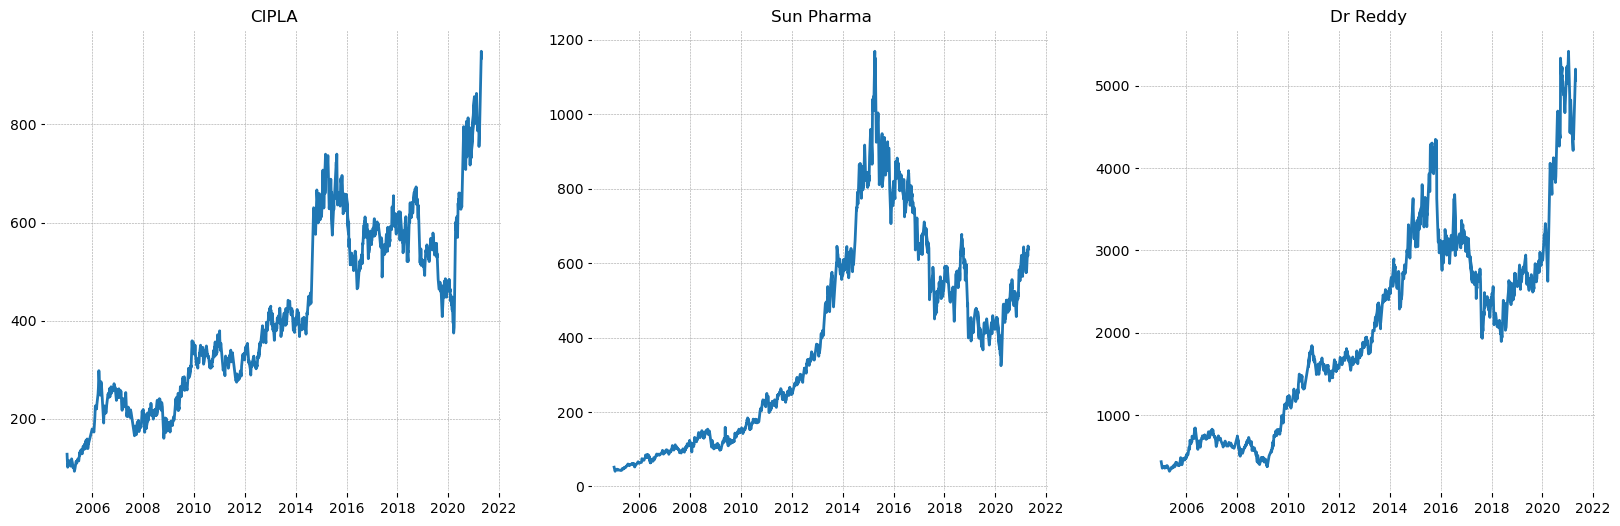

In [106]:
fig,ax=plt.subplots(1,3,figsize=(20,6))
ax[0].plot(cipla.Close)
ax[0].set_title('CIPLA')
ax[1].plot(sunp.Close)
ax[1].set_title('Sun Pharma')
ax[2].plot(drreddy.Close)
ax[2].set_title('Dr Reddy')
fig.show()

Pandas dataframe.rolling() function provides the feature of rolling window calculations. The concept of rolling window calculation is most primarily used in signal processing and time series data. In a very simple words we take a window size of k at a time and perform some desired mathematical operation on it. A window of size k means k consecutive values at a time. In a very simple case all the ‘k’ values are equally weighted.

In [107]:
rolling_window = cipla['Close'].rolling('90D')

In [108]:
rolling_window=pd.DataFrame(rolling_window)

In [109]:
rolling_window.mean()

Date
2005-01-03    127.620003
2005-01-04    127.160004
2005-01-05    120.300003
2005-01-06    117.059998
2005-01-07    116.699997
                 ...    
2021-04-16    938.049988
2021-04-19    946.299988
2021-04-20    949.299988
2021-04-22    944.349976
2021-04-23    935.599976
Length: 4015, dtype: float64

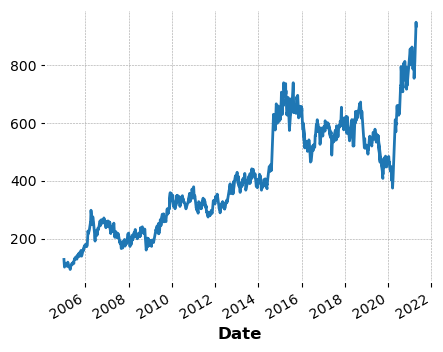

In [110]:
rcParams['figure.figsize'] = 5, 4
rolling_window.mean().plot()
# Plotting a rolling mean of 90 day window with original High attribute of google stocks
plt.show()

### Candlestick Visualization

In [111]:
import mplfinance as mpf
import datetime
x=datetime.datetime.now()
y=str(x.year-2)+'-'+str(x.strftime("%m"))

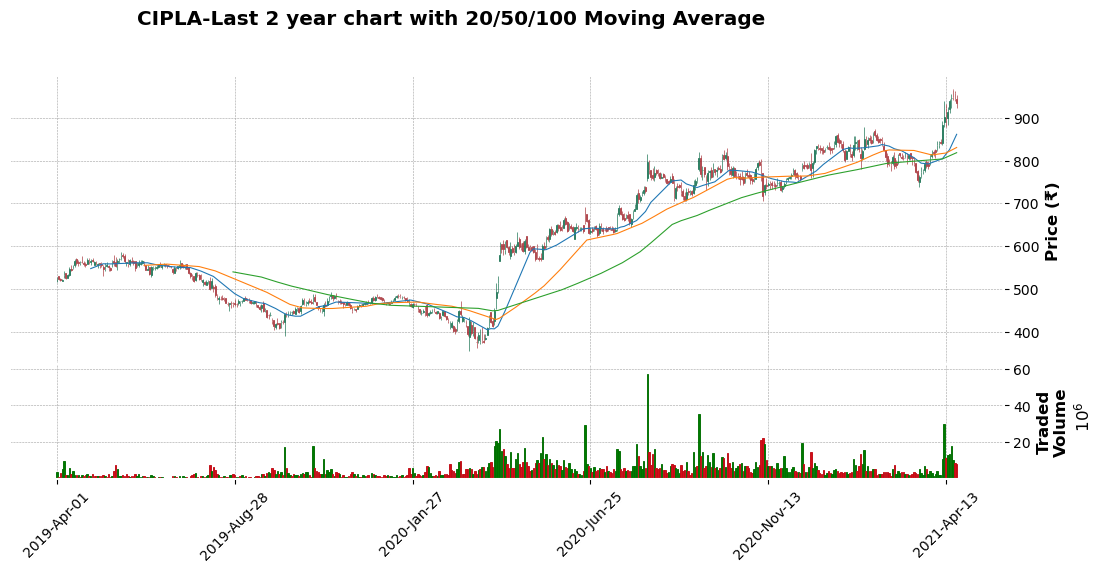

In [112]:
s  = mpf.make_mpf_style(base_mpf_style='charles',mavcolors=['#1f77b4','#ff7f0e','#2ca02c'])
mpf.plot(cipla[y:],
         volume=True,
         type='candle',
        figratio=(24,10),
         mav=(20,50,100),
         style= s,
         ylabel='Price (₹)',
         title='CIPLA-Last 2 year chart with 20/50/100 Moving Average',
         ylabel_lower='Traded\nVolume',
         tight_layout=False,
         #savefig=dict(fname=figsave("Year"),dpi=1200)
         #show_nontrading=True if needed to show trading day gaps
        )

In [113]:
cipla.Close.describe()

count    4015.000000
mean      409.534560
std       182.232892
min        92.839996
25%       255.049995
50%       382.799988
75%       566.324982
max       949.299988
Name: Close, dtype: float64

Let's go one step further and compute the daily growth of the stock prices compared to day 1 of the prices(i.e compute cumalative compound growth)

In [114]:
first = cipla.Close[0]
decline=(first-cipla.Close.min())/first
max_return=(cipla.Close.max()-cipla.Close.min())/cipla.Close.min()
print("Max Decline since IPO                -{}%".format(round(decline*100)))
print("Max Return If bought at lowest       +{}%".format(round(max_return*100)))
print('Return If Holding from IPO           +{}%'.format(round(((cipla.Close[-1]-first)/first)*100)))
print("Max Return seen by investor from IPO +{}%".format(round(((cipla.Close.max()-first)/first)*100)))

Max Decline since IPO                -27%
Max Return If bought at lowest       +923%
Return If Holding from IPO           +633%
Max Return seen by investor from IPO +644%


## Trends, seasonality and noise
These are the components of a time series

- Trend - Consistent upwards or downwards slope of a time series
- Seasonality - Clear periodic pattern of a time series(like sine funtion)
- Noise - Outliers or missing values

In [115]:
from statsmodels.tsa.seasonal import seasonal_decompose

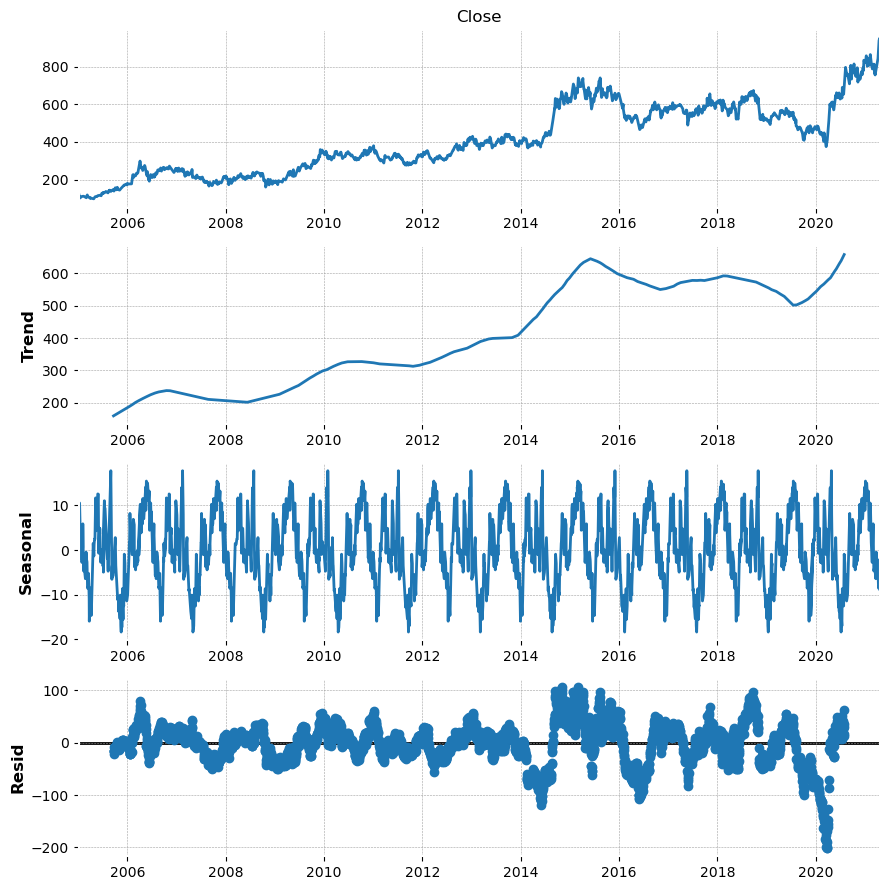

In [116]:
rcParams['figure.figsize'] = 9, 9

decomposed=seasonal_decompose(cipla["Close"],freq=360)
# The frequncy is annual
decomposed.plot()

plt.show()

- There is clearly an upward trend in the above plot.
- You can also see the uniform seasonal change.
- Non-uniform noise that represent outliers and missing values

### What is Stationarity?
In order for time series data to be stationary, the data must exhibit four properties over time:
1. constant mean
2. constant variance
3. constant autocorrelation structure
4. no periodic component

### INFERENCE  
Our data is not stationary

### Confirming Tests:-
Identifying Stationarity :- 
1. Run-sequence plots
2. Summary statistics & histogram plots
3. Augmented Dickey-Fuller test

Text(0, 0.5, 'Price in INR')

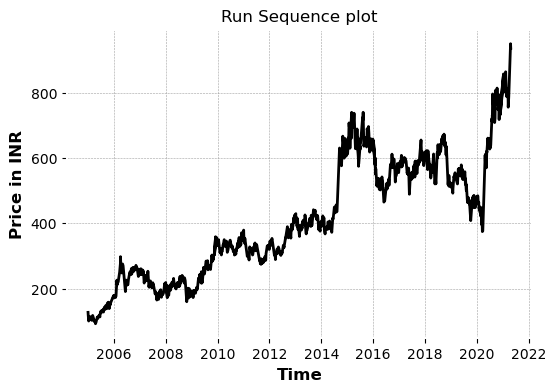

In [117]:
#1. Run_sequence plot

rcParams['figure.figsize'] = 6,4
plt.plot(cipla.index, cipla.Close, 'k-')
plt.title("Run Sequence plot")
plt.xlabel("Time")
plt.ylabel("Price in INR")

### Run-Sequence Plots
Run-sequence plots should be old hat by now. They are the go-to technique to visualize what's happening with your data. You should always start here. Don't bother building a model until you've done this.

In order to be thorough, let's plot the nonstationary data from above that has trend and seasonality components.

## 2.Summary Statistics & Plots
the easiest way to check for constant mean and variance is to chop up the data into separate chunks, calculate statistics for each chunk, and compare. It's not the most rigorous method but it gives you a good sense of whether your data is approximately stationary.

In [118]:
# split data into 10 chunks
chunks = np.split(cipla.Close[15:].values, indices_or_sections=10)

In [119]:
chunks[0][:500:20]

array([109.300003, 106.019997, 104.139999,  97.800003, 109.360001,
       113.980003, 132.399994, 138.059998, 145.479996, 147.199997,
       152.059998, 173.440002, 178.119995, 220.679993, 230.720001,
       290.380005, 271.049988, 198.350006, 215.699997, 232.949997])

In [120]:
# compare means and variances
print("{} | {:7} | {}".format("Chunk", "Mean", "Variance"))
print("-" * 26)
for i, chunk in enumerate(chunks, 1):
    print("{:5} | {:.6} | {:.6}".format(i, np.mean(chunk), np.var(chunk)))

Chunk | Mean    | Variance
--------------------------
    1 | 170.209 | 2931.3
    2 | 217.488 | 871.968
    3 | 230.282 | 1373.91
    4 | 328.281 | 303.968
    5 | 338.348 | 1663.56
    6 | 421.925 | 3207.03
    7 | 626.186 | 4146.14
    8 | 569.097 | 1052.99
    9 | 566.568 | 2382.11
   10 | 638.126 | 24566.0


#### INFERENCE

While the variance and the mean is clearly changing, which means this data is not stationary. 

> Note: We do expect some fluctuation in values. It's highly unlikely that the either the mean or variace will be exactly the same from chunk to chunk, but it should be close. 

If we wanted to get even more sophisticated, we could run a statistical test to determine if the difference in means or the difference in variances is statistically significant.

<AxesSubplot:>

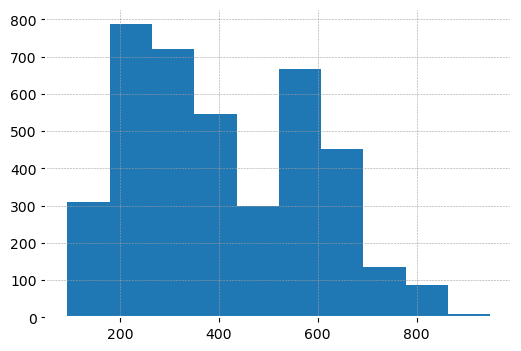

In [121]:
#Histogram Plot
cipla.Close.hist()

Stationary Data Histogram Plot beahves likes **Normal Distributon** , whereas our data provide so such indication.


### 3. Augmented Dickey-Fuller Test
This is a statistical procedure to suss out whether a time series is stationary or not. Where:-
1. **Null hypothesis:** the series is nonstationary.
2. **Alternative hypothesis:** the series is stationary.

Like any statistical test you should set a significance level or threshold that determines whether you should accept or reject the null. 
> The value 0.05 is common but depends upons numerous factors.

In [122]:
from statsmodels.tsa.stattools import adfuller

adf= adfuller(cipla.Close.values)

In [123]:
print(adf[0])

-0.21573709105155586


First, **adf** is the value of the test statistic. The more negative the value, the more confident we can be that the series is stationary. Here we see a value of -10. That may not mean anything to you just yet but the **pvalue** should.

In [124]:
print("p-value",adf[1])

p-value 0.9366196161865998


As expected, we fail to reject the null hypothesis hence data is not stationary.

## Making Data Stationary

In [125]:
#Using Residuals

cip_res=decomposed.resid

In [126]:
cip_res[180:-180]

Date
2005-09-20    -8.274797
2005-09-21   -15.856347
2005-09-22   -16.343548
2005-09-23   -21.309373
2005-09-26   -15.636045
                ...    
2020-07-27    12.396858
2020-07-28    15.875601
2020-07-29    29.237064
2020-07-30    34.961478
2020-07-31    62.791981
Name: resid, Length: 3655, dtype: float64

In [127]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(cip_res[180:-180])
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -5.460643836151231
p-value:  2.5231850280506015e-06


Text(0, 0.5, 'Price in INR')

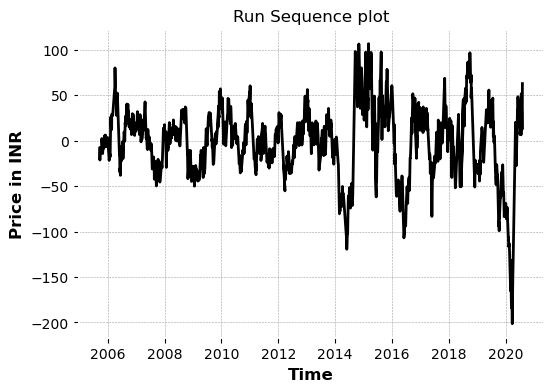

In [128]:
rcParams['figure.figsize'] = 6,4
plt.plot(cipla.index[180:-180], cip_res[180:-180], 'k-')
plt.title("Run Sequence plot")
plt.xlabel("Time")
plt.ylabel("Price in INR")

Now it's stationary!

### 2. Log-Transformation

Text(0, 0.5, 'Price in INR')

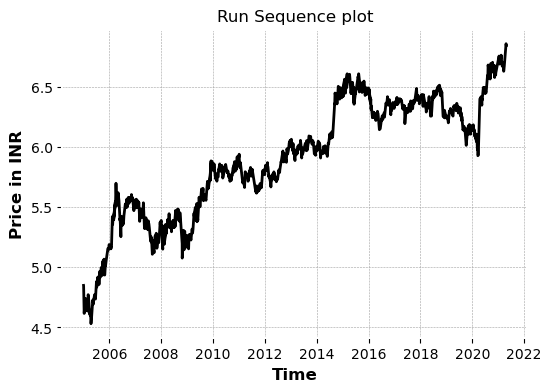

In [129]:
rcParams['figure.figsize'] = 6,4
plt.plot(cipla.index, np.log(cipla.Close.values), 'k-')
plt.title("Run Sequence plot")
plt.xlabel("Time")
plt.ylabel("Price in INR")

Notice how the variance has collapsed to a large extent.

In [130]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller( np.log(cipla.Close.values))
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -1.3869893924019037
p-value:  0.5884974295339067


In [131]:
#Adding Log Transformed Price
cipla['price']=np.log(cipla.Close.values)

<AxesSubplot:>

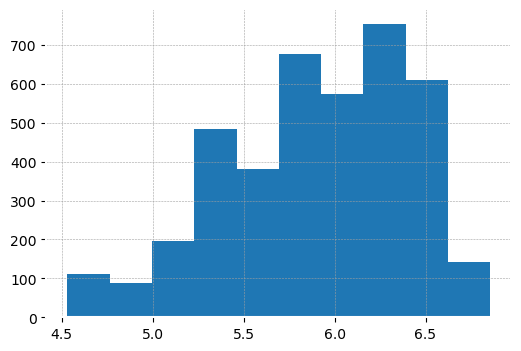

In [132]:
#Histogram Plot - Log Transformed
cipla.price.hist()

As somewhat trend can be managed we will go with this.

### MSE Function for smoothing

In [133]:
def mse(observations, estimates):
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse

In [134]:
train=cipla.price.values[:-500]
test=cipla.price.values[-500:]

In [135]:
train_idx=cipla.index.values[:-500]
test_idx=cipla.index.values[-500:]

#### Simple Average

In [136]:
simple_avg_preds=np.mean(cipla.price.values)
simple_avg_preds = np.full(shape=len(test), fill_value=simple_avg_preds, dtype='float')

simple_mse = mse(test, simple_avg_preds)

# results
print("Predictions: ", simple_avg_preds[:5])
print("MSE: ", simple_mse)

Predictions:  [5.9026885 5.9026885 5.9026885 5.9026885 5.9026885]
MSE:  151.11184402134415


Text(0.5, 1.0, 'Simple Average Smoothing')

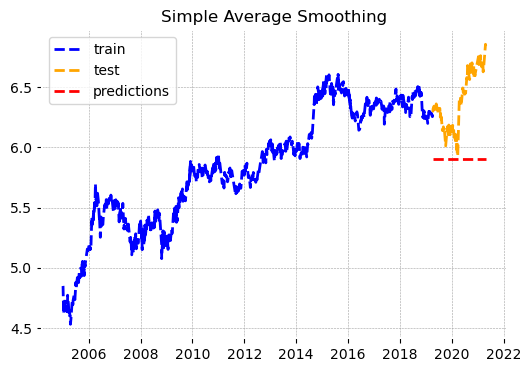

In [137]:
plt.plot(train_idx, train, 'b--', label="train")
plt.plot(test_idx, test, color='orange', linestyle="--", label="test")
plt.plot(test_idx, simple_avg_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Simple Average Smoothing")


## Single Expo. Smoothing

In [138]:
from statsmodels.tsa.api import SimpleExpSmoothing

single = SimpleExpSmoothing(train).fit(optimized=True)
single_preds = single.forecast(len(test))
single_mse = mse(test, single_preds)
print("Predictions: ", single_preds[:5])
print("MSE: ", single_mse)

Predictions:  [6.27664349 6.27664349 6.27664349 6.27664349 6.27664349]
MSE:  36.02137713708234


Text(0.5, 1.0, 'Single Exponential Smoothing')

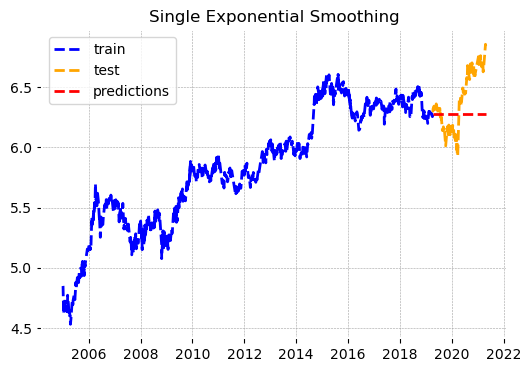

In [139]:
plt.plot(train_idx, train, 'b--', label="train")
plt.plot(test_idx, test, color='orange', linestyle="--", label="test")
plt.plot(test_idx, single_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Single Exponential Smoothing")

### Double Exponential Smoothing

In [140]:
from statsmodels.tsa.api import Holt

double = Holt(train).fit(optimized=True)
double_preds = double.forecast(len(test))
double_mse = mse(test, double_preds)
print("Predictions: ", double_preds[:5])
print("MSE: ", double_mse)

Predictions:  [6.27704114 6.27744747 6.27785381 6.27826014 6.27866648]
MSE:  19.455990122776107


Text(0.5, 1.0, 'Double Exponential Smoothing')

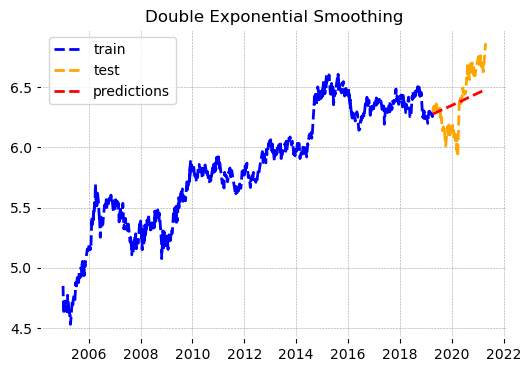

In [141]:
plt.plot(train_idx, train, 'b--', label="train")
plt.plot(test_idx, test, color='orange', linestyle="--", label="test")
plt.plot(test_idx, double_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Double Exponential Smoothing")

### Triple Exponential Smoothing

In [142]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

triple = ExponentialSmoothing(train,
                              trend="add",
                              seasonal=None,
                              seasonal_periods=None
                              ).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mse(test, triple_preds)
print("Predictions: ", triple_preds[:5])
print("MSE: ", triple_mse)

Predictions:  [6.27704114 6.27744747 6.27785381 6.27826014 6.27866648]
MSE:  19.455990122776107


Text(0.5, 1.0, 'Triple Exponential Smoothing')

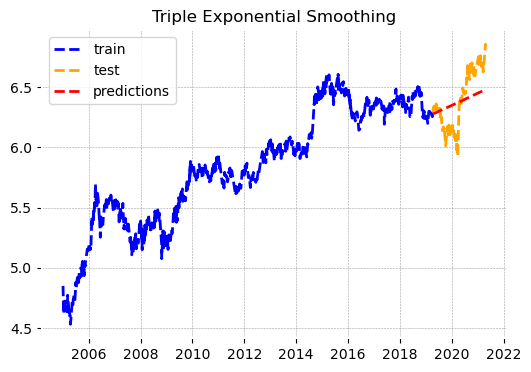

In [143]:
plt.plot(train_idx, train, 'b--', label="train")
plt.plot(test_idx, test, color='orange', linestyle="--", label="test")
plt.plot(test_idx, triple_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing")

## Autocorrelation and Partial Autocorrelation plot

In [145]:
import statsmodels.tsa.api as smt
import statsmodels

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'): # [3]
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = statsmodels.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

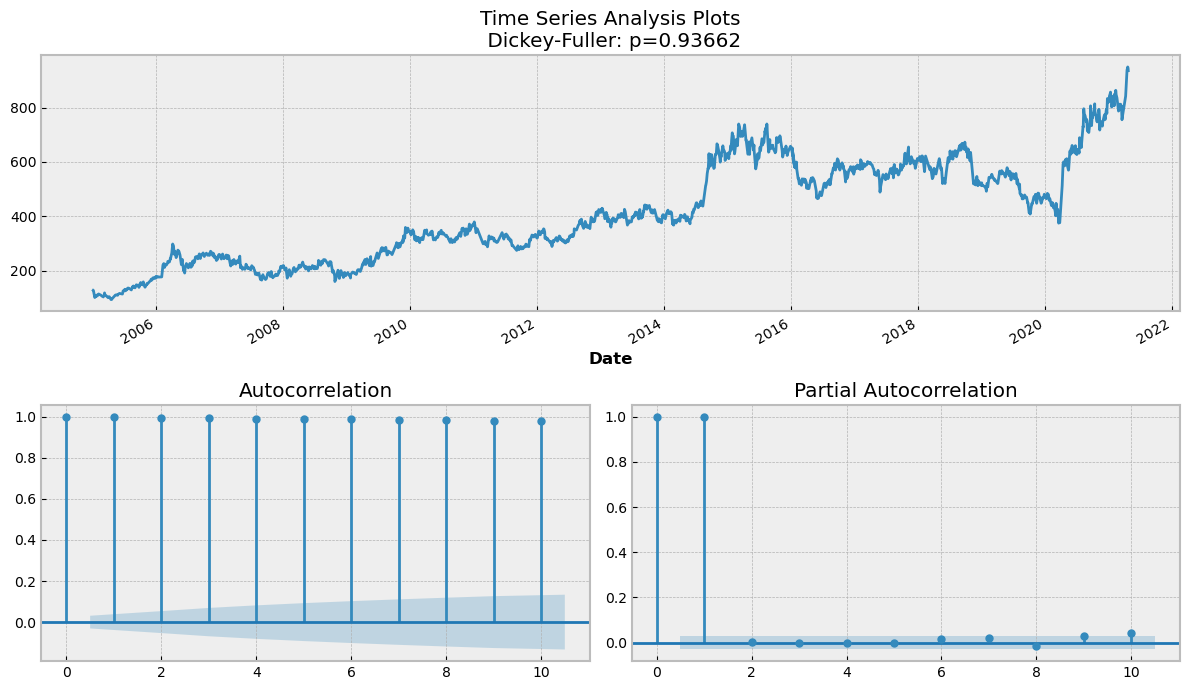

In [146]:
tsplot(cipla.Close, lags=10)

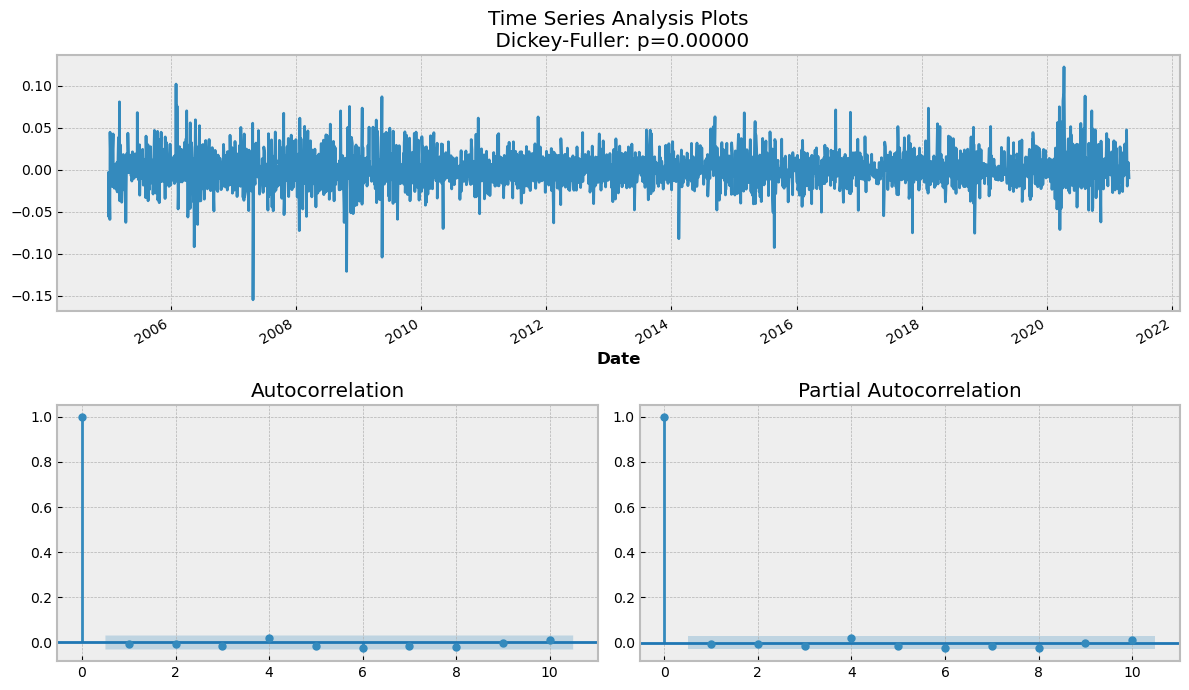

In [147]:
tsplot(cipla.price.diff(1).dropna(), lags=10)

## AR MODEL




In [148]:
train_ar=cipla[:-500]
test_ar=cipla[-500:]

In [149]:
train_ar=train_ar.drop(['Open','High','Low','Close','Adj Close','Volume'],axis=1)

In [150]:
test_ar=test_ar.drop(['Open','High','Low','Close','Adj Close','Volume'],axis=1)

In [161]:
train_ar

,price
Date,
2005-01-03,4.849057
2005-01-04,4.845446
2005-01-05,4.789989
2005-01-06,4.762687
2005-01-07,4.759607
...,...
2019-04-03,6.254694
2019-04-04,6.255750
2019-04-05,6.276831


In [151]:
start = len(train_ar)
end = start + len(test_ar) - 1

In [152]:
from statsmodels.tsa.ar_model import AR, ARResults

model_ar = AR(train_ar['price'])
model_ar_fit1 = model_ar.fit(maxlag = 1)
prediction_ar1 = model_ar_fit1.predict(start, end).rename("AR(1) Model")

model_ar = AR(train_ar['price'])
model_ar_fit2 = model_ar.fit(maxlag = 2)
prediction_ar2 = model_ar_fit2.predict(start, end).rename("AR(2) Model")

model_ar = AR(train_ar['price'])
model_ar_fit3 = model_ar.fit(maxlag = 3)
prediction_ar3 = model_ar_fit3.predict(start, end).rename("AR(3) Model")

model_ar = AR(train_ar['price'])
model_ar_fit4 = model_ar.fit(maxlag = 4)
prediction_ar4 = model_ar_fit4.predict(start, end).rename("AR(4) Model")

In [153]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

labels = ["AR-1","AR-2", "AR-3", "AR-4"]
preds = [prediction_ar1,prediction_ar2,prediction_ar3,prediction_ar4]

for i in range(4):
    error = mean_squared_error(test_ar['price'], preds[i])
    print(f'{labels[i]} MSE -> {error}')

AR-1 MSE -> 0.08391858382744663
AR-2 MSE -> 0.08400507086286929
AR-3 MSE -> 0.08447164515937848
AR-4 MSE -> 0.08344285967012309


In [154]:
test_ar['predict1']=[x for x in prediction_ar1.to_numpy()]
test_ar['predict2']=[x for x in prediction_ar2.to_numpy()]
test_ar['predict3']=[x for x in prediction_ar3.to_numpy()]
test_ar['predict4']=[x for x in prediction_ar4.to_numpy()]

<AxesSubplot:xlabel='Date'>

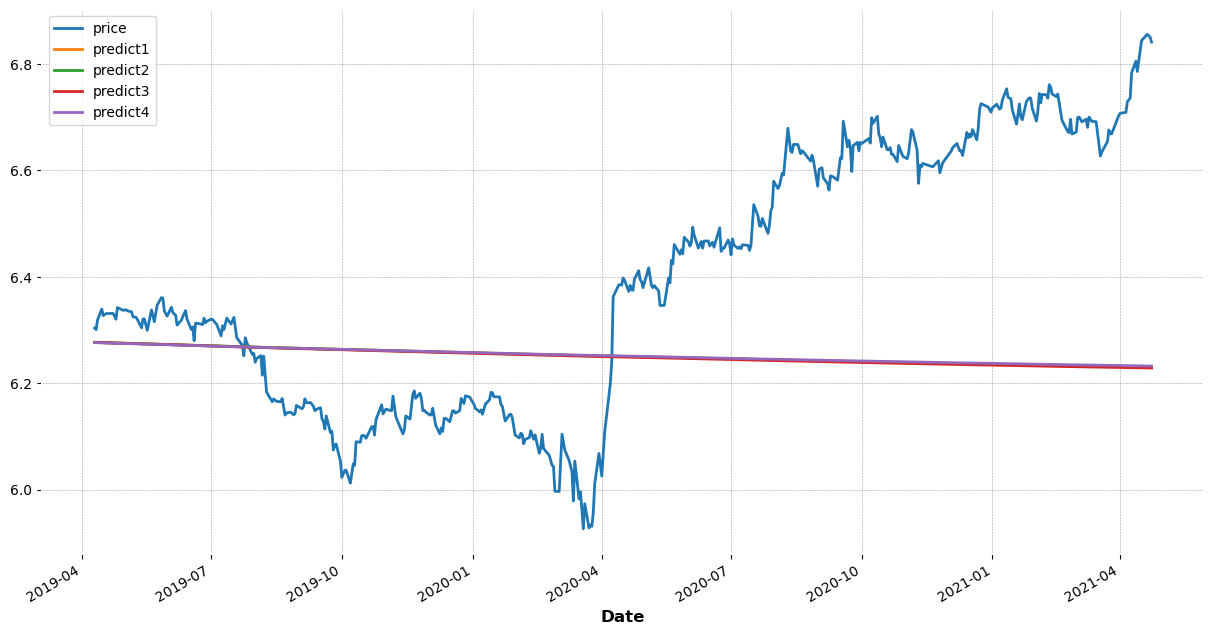

In [155]:
test_ar.price.plot(figsize = (15,8), legend = True)
test_ar.predict1.plot(legend = True)
test_ar.predict2.plot(legend = True)
test_ar.predict3.plot(legend = True)
test_ar.predict4.plot(legend = True)

## ARIMA Model

In [156]:
#!pip install pmdarima
from pmdarima import auto_arima

In [162]:
auto_arima(train_ar['price']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3515
Model:               SARIMAX(0, 1, 0)   Log Likelihood                9070.249
Date:                Wed, 28 Apr 2021   AIC                         -18138.498
Time:                        13:58:19   BIC                         -18132.334
Sample:                             0   HQIC                        -18136.299
                               - 3515                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   4.49e-06     74.637      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2793.29
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [163]:
from statsmodels.tsa.arima_model import ARMA,ARIMA,ARMAResults, ARIMAResults

In [175]:
model_arima = ARIMA(train_ar['price'], order=(0,1,0)).fit()
arima_pr = model_arima.predict(start, end,typ = "levels")

In [177]:
test_ar['predict_arima']=[x for x in arima_pr.to_numpy()]

<AxesSubplot:xlabel='Date'>

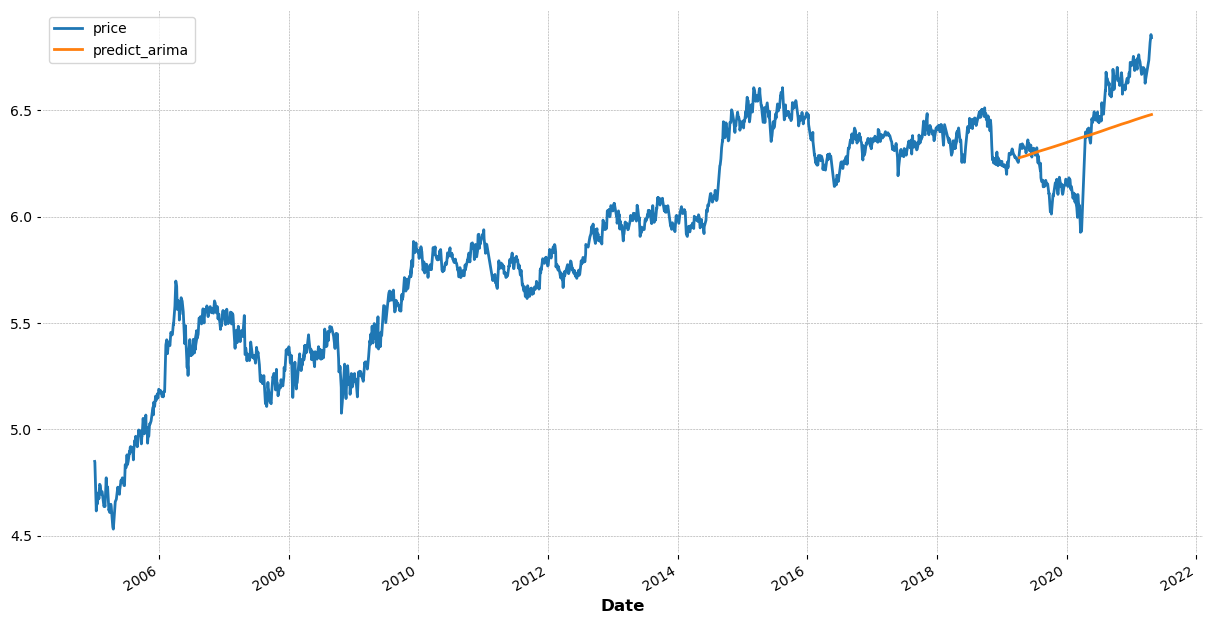

In [179]:
cipla.price.plot(figsize = (15,8),legend = True)
test_ar.predict_arima.plot(legend = True)

### ARMA

In [172]:
from statsmodels.tsa.stattools import ARMA

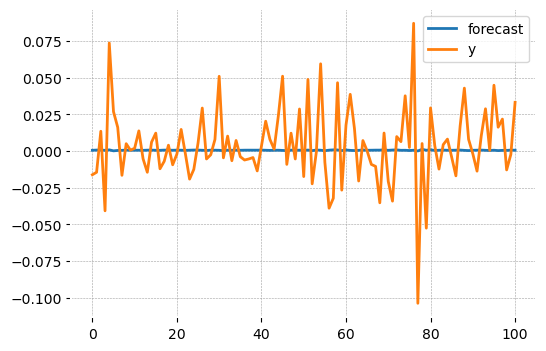

In [173]:
cip_ar=ARMA(cipla["price"].diff().iloc[1:].values, order=(1,0))
res = cip_ar.fit()
res.plot_predict(start=1000, end=1100)
plt.show()

## Train Test Split

In [227]:
#Taking Trainning Dataset
train_len=int(len(data)*.85)
train_len

3412

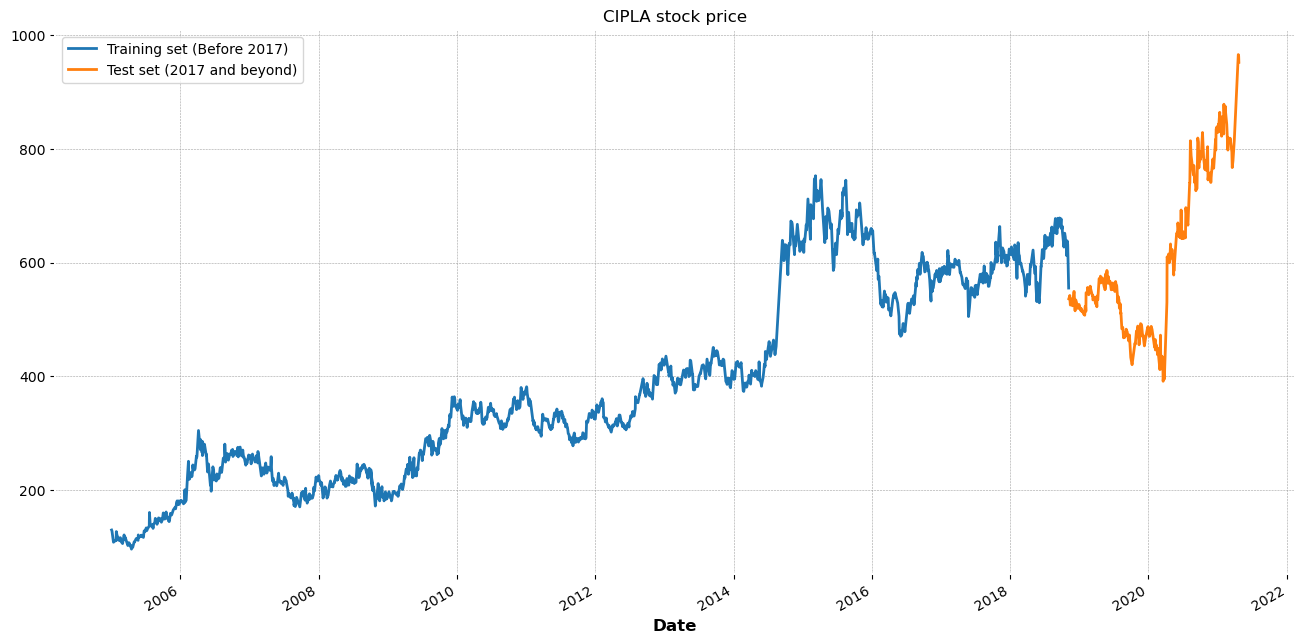

In [284]:
# We have chosen 'Close' attribute for prices. Let's see what it looks like
cipla["High"][0:train_len].plot(figsize=(16,8),legend=True)
cipla["High"][train_len:].plot(figsize=(16,8),legend=True)
plt.legend(['Training set 85%','Test set 15%'])
plt.title('CIPLA stock price')
plt.show()

In [225]:
data=cipla.filter(['Close']).values

In [229]:
from sklearn.preprocessing import MinMaxScaler

# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
data = sc.fit_transform(data)

In [231]:
train_data=data[0:train_len,:]
x_train=[]
y_train=[]

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=61:
        print(x_train)
        print(y_train)
        print()

[array([0.04060903, 0.04007193, 0.03206222, 0.0282792 , 0.02785886,
       0.02325854, 0.01683675, 0.00966771, 0.01508536, 0.01585597,
       0.01422133, 0.01354413, 0.01601943, 0.01835463, 0.02017608,
       0.01921865, 0.01669664, 0.0198258 , 0.02543027, 0.02344535,
       0.0245896 , 0.02515004, 0.0246363 , 0.02176401, 0.01933541,
       0.01961563, 0.02047965, 0.02068982, 0.02082993, 0.01975575,
       0.0198258 , 0.01977909, 0.01858815, 0.01562245, 0.01672   ,
       0.01538893, 0.01218971, 0.01242324, 0.01331061, 0.01282022,
       0.01214301, 0.01688346, 0.01779418, 0.01615955, 0.01884502,
       0.02958691, 0.02461294, 0.02251128, 0.02012938, 0.0240058 ,
       0.02391239, 0.02335194, 0.02075988, 0.01968568, 0.01485183,
       0.01319385, 0.00992457, 0.01169933, 0.00880368, 0.00889709])]
[0.011068822932245037]

[array([0.04060903, 0.04007193, 0.03206222, 0.0282792 , 0.02785886,
       0.02325854, 0.01683675, 0.00966771, 0.01508536, 0.01585597,
       0.01422133, 0.01354413, 0.0

In [232]:
#Convert x_train and y_train to numpy array
x_train,y_train=np.array(x_train),np.array(y_train)

In [233]:
x_train.shape

(3352, 60)

In [234]:
#Reshape data ( 3D data is requried by LSTM)

x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(3352, 60, 1)

# LSTM Model

In [235]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [238]:
#Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
#Compile
model.compile(optimizer='adam',loss='mean_squared_error')
#Train
model.fit(x_train,y_train,batch_size=10,epochs=50)

Epoch 1/50
336/336 [==============================] - 7s 20ms/step - loss: 0.0020: 0s - loss:
Epoch 2/50
336/336 [==============================] - 7s 20ms/step - loss: 3.7565e-04
Epoch 3/50
336/336 [==============================] - 7s 20ms/step - loss: 3.2089e-04
Epoch 4/50
336/336 [==============================] - 7s 20ms/step - loss: 2.4453e-04
Epoch 5/50
336/336 [==============================] - 7s 21ms/step - loss: 2.6031e-04
Epoch 6/50
336/336 [==============================] - 7s 21ms/step - loss: 2.1725e-04
Epoch 7/50
336/336 [==============================] - 7s 21ms/step - loss: 1.8382e-04: 1s
Epoch 8/50
336/336 [==============================] - 7s 20ms/step - loss: 1.8056e-04
Epoch 9/50
336/336 [==============================] - 7s 21ms/step - loss: 1.6447e-04
Epoch 10/50
336/336 [==============================] - 7s 21ms/step - loss: 1.4403e-04- ETA: 2s -  - ETA: 
Epoch 11/50
336/336 [==============================] - 7s 21ms/step - loss: 1.3245e-04: 2s - loss: 1
Epoch 

In [239]:
#create tesing data set
test_data=data[train_len-60:,:]
print(len(test_data))

x_test=[]
y_test=[]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    y_test.append(test_data[i,0])


663


In [240]:
x_test=np.array(x_test)
y_test=np.array(y_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))


In [270]:
y_test.shape

(603,)

In [248]:
#get model predicted price values
predict=model.predict(x_test)
predictf=sc.inverse_transform(predict)

In [276]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Cipla Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Cipla Stock Price')
    plt.title('Cipla Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Cipla Stock Price')
    plt.legend()
    plt.show()

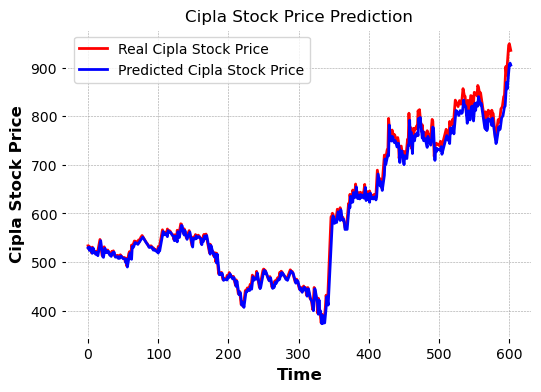

In [277]:
# Visualizing the results for LSTM
plot_predictions(sc.inverse_transform(y_test.reshape(-1,1)),predictf)

In [262]:
#Evaluating the model using RMSE
rmse=np.sqrt(np.mean(predictf-sc.inverse_transform(y_test.reshape(-1,1)))**2)
rmse

7.442883252238157

# GRU Model

In [253]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training setiiii
regressorGRU.fit(x_train,y_train,epochs=50,batch_size=10)

Epoch 1/50
336/336 [==============================] - 16s 48ms/step - loss: 0.0074
Epoch 2/50
336/336 [==============================] - 16s 47ms/step - loss: 0.0015
Epoch 3/50
336/336 [==============================] - 17s 49ms/step - loss: 0.0012
Epoch 4/50
336/336 [==============================] - 18s 54ms/step - loss: 0.0012
Epoch 5/50
336/336 [==============================] - 16s 49ms/step - loss: 0.0011
Epoch 6/50
336/336 [==============================] - 17s 50ms/step - loss: 0.0011 0s - 
Epoch 7/50
336/336 [==============================] - 16s 48ms/step - loss: 0.0011
Epoch 8/50
336/336 [==============================] - 16s 47ms/step - loss: 0.0010 2s -  - ET
Epoch 9/50
336/336 [==============================] - 16s 48ms/step - loss: 9.7116e-04
Epoch 10/50
336/336 [==============================] - 16s 49ms/step - loss: 0.0010
Epoch 11/50
336/336 [==============================] - 17s 49ms/step - loss: 8.9133e-04 2s - loss: - E
Epoch 12/50
336/336 [========================

In [255]:
GRU_predicted_stock_price = regressorGRU.predict(x_test)
GRU_predicted_stock_price_sc= sc.inverse_transform(GRU_predicted_stock_price)

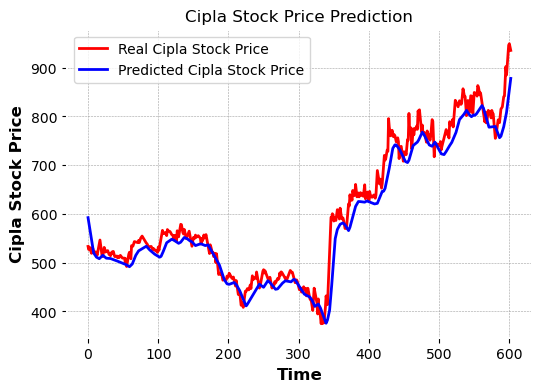

In [278]:
# Visualizing the results for GRU
plot_predictions(sc.inverse_transform(y_test.reshape(-1,1)),GRU_predicted_stock_price_sc)

In [259]:
#Evaluating the model using RMSE
rmse=np.sqrt(np.mean(GRU_predicted_stock_price_sc-sc.inverse_transform(y_test.reshape(-1,1)))**2)
rmse

19.50705377333061

## Sequence Generation

The above models make use of test set so it is using last 60 true values for predicting the new value(I will call it a benchmark). This is why the error is so low. Strong models can bring similar results like above models for sequences too but they require more than just data which has previous values. In case of stocks, we need to know the sentiments of the market, the movement of other stocks and a lot more. So, don't expect a remotely accurate plot. The error will be great and the best I can do is generate the trend similar to the test set.

I will use GRU model for predictions. We can try this using LSTMs also.

The GRU model in the previous versions is fine too. Just a little tweaking was required to get good sequences. **The main goal of this kernel is to show how to build RNN models. How you predict data and what kind of data you predict is up to you.**

In [285]:
# Preparing sequence data
initial_sequence = x_train[3291,:]

sequence = []
for i in range(553):
    new_prediction = regressorGRU.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)
sequence = sc.inverse_transform(np.array(sequence).reshape(553,1))

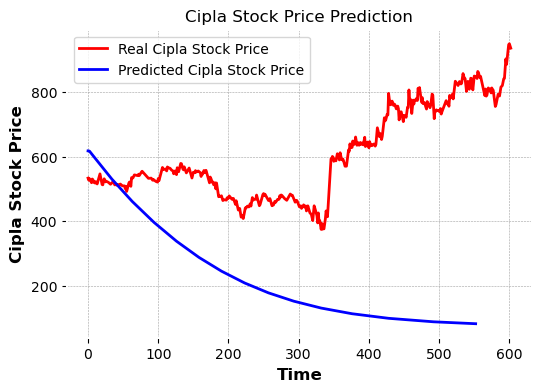

In [286]:
# Visualizing the sequence
plot_predictions(sc.inverse_transform(y_test.reshape(-1,1)),sequence)

## Survial Analysis of Volume with price

In [280]:
from lifelines import KaplanMeierFitter, CoxPHFitter 

Text(0, 0.5, 'Survival probability')

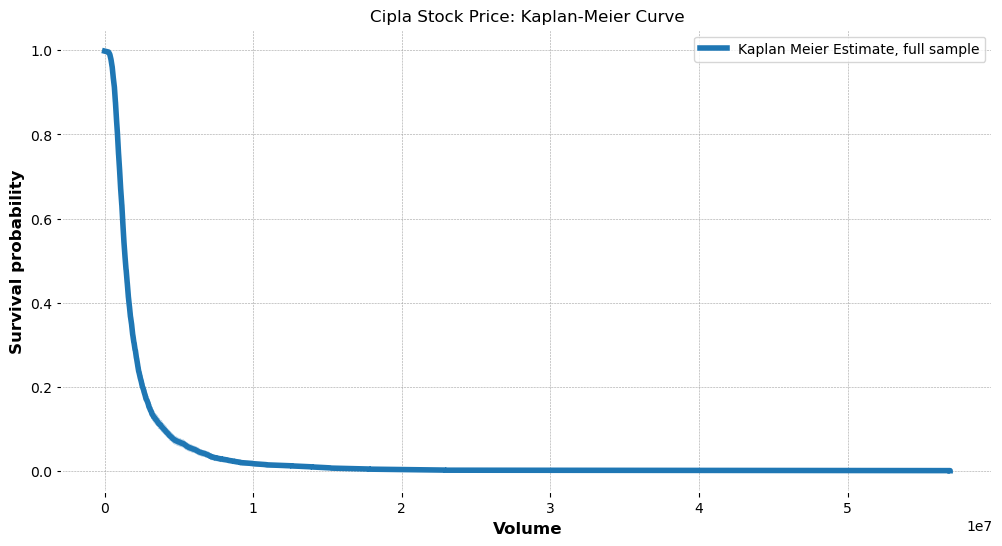

In [283]:
kmf = KaplanMeierFitter()

kmf.fit( cipla.Volume,cipla.Close, label = 'Kaplan Meier Estimate, full sample')

kmf.plot(linewidth=4, figsize=(12, 6))
plt.title('Cipla Stock Price: Kaplan-Meier Curve')
plt.xlabel('Volume')
plt.ylabel('Survival probability')


## Conclusion

LSTM model perform better in our case.

In case of stocks, we need to know the sentiments of the market, the movement of other stocks and a lot more. So, don't expect a remotely accurate plot. The error will be great and the best I can do is generate the trend similar to the test set.

Therefore in case of sequence generation our model cann't predict good.

AIRMA model can be used for long term trend indication weather to go LONG or SHORT.

## Further Developments

As stock price need very huge data and many indicatiors of economy which require high computaional resources. We can work on Google Colab with adding extra columns such as :-
- Global Markets Trend
- Nifty Index Trend
- GDP Trend
- Sectorial Trend
- Peer Comparision , etc.

we can add more LSTM layers with dropout layer to improve our model.

Times series can work well with sentence generation , Blood pressure tracking, weight tracking, cholesterol measurements, heart rate monitoring, Birth rates, population, migration data, political indicators , etc.